In [3]:
import pandas as pd, numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [6]:
df = pd.read_csv('/Users/calvi/Downloads/archive (5)/Base.csv')

In [8]:
y = df["fraud_bool"].astype(int)
X = df.drop(columns=["fraud_bool"])

# One-hot encode categoricals
Xdm = pd.get_dummies(X, drop_first=True)

print("Shape after dummies:", Xdm.shape)
print("Fraud rate:", y.mean())

# Train/test split
X_tr, X_te, y_tr, y_te = train_test_split(
    Xdm, y, test_size=0.2, stratify=y, random_state=42
)

Shape after dummies: (1000000, 47)
Fraud rate: 0.011029


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

logreg = LogisticRegression(
    solver="saga",            # good for large sparse data
    penalty="l2",
    C=0.5,                    # regularization strength
    class_weight="balanced",  # helps with imbalance
    max_iter=300,             # keep modest for speed
    tol=1e-3,
    n_jobs=-1
)

logreg.fit(X_tr, y_tr)
p_lr = logreg.predict_proba(X_te)[:,1]

print("\n=== Logistic Regression ===")
print("ROC-AUC:", roc_auc_score(y_te, p_lr), " | PR-AUC:", average_precision_score(y_te, p_lr))
print(classification_report(y_te, (p_lr>=0.5).astype(int), digits=4))


=== Logistic Regression ===
ROC-AUC: 0.7285102619334597  | PR-AUC: 0.03640389233827515
              precision    recall  f1-score   support

           0     0.9943    0.6862    0.8120    197794
           1     0.0225    0.6478    0.0435      2206

    accuracy                         0.6858    200000
   macro avg     0.5084    0.6670    0.4277    200000
weighted avg     0.9836    0.6858    0.8035    200000



/Users/calvi/Downloads/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ROC-AUC - 0.73, PR-AUC = 0.036

Recall (fraud) = 65% → it catches a decent share of frauds.

Precision (fraud) = 2% → almost everything it flags as fraud is a false alarm.

Story: It’s finding frauds, but at the cost of spamming tons of false positives. Weak overall separation of classes.

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=200,             # number of trees
    max_depth=12,                 # cap depth to keep fast
    min_samples_leaf=5,           # regularize leaves
    max_features="sqrt",
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)

rf.fit(X_tr, y_tr)
p_rf = rf.predict_proba(X_te)[:,1]

print("\n=== Random Forest ===")
print("ROC-AUC:", roc_auc_score(y_te, p_rf), " | PR-AUC:", average_precision_score(y_te, p_rf))
print(classification_report(y_te, (p_rf>=0.5).astype(int), digits=4))



=== Random Forest ===
ROC-AUC: 0.8757138770099291  | PR-AUC: 0.13002705415253465
              precision    recall  f1-score   support

           0     0.9955    0.9036    0.9473    197794
           1     0.0680    0.6310    0.1228      2206

    accuracy                         0.9005    200000
   macro avg     0.5317    0.7673    0.5350    200000
weighted avg     0.9852    0.9005    0.9382    200000



ROC-AUC = 0.876, PR-AUC = 0.13

Recall (fraud) = 63% meaning it catches about 2 out of 3 frauds.

Precision (fraud) = 7% shows theres a lot of false alarms, but its around 3–4× better than LR.

Much stronger class separation, more stable results

Story: Clearly outperforms logistic regression. Better balance of recall and precision, and a PR-AUC ~12× baseline fraud rate (~1%).

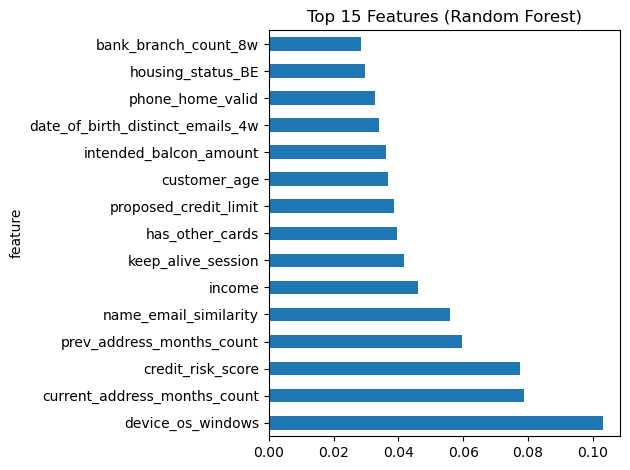

In [15]:
import pandas as pd
import numpy as np

# Get importances
importances = rf.feature_importances_
feat_names = Xdm.columns
imp_df = pd.DataFrame({"feature": feat_names, "importance": importances})
imp_df = imp_df.sort_values("importance", ascending=False).head(15)

# Plot
imp_df.plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 15 Features (Random Forest)")
plt.tight_layout()
plt.show()